<a href="https://colab.research.google.com/github/VinayChavan2006/EE655-Computer-Vision-and-Deep-Learning/blob/main/Assignment-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# import libraries
import numpy as np
import torch
from torchvision import datasets
import cv2

mnist_train = datasets.MNIST(root='./data', train=True, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True)

images_train = mnist_train.data.numpy()
images_test = mnist_test.data.numpy()
labels_train = mnist_train.targets.numpy()
labels_test = mnist_test.targets.numpy()

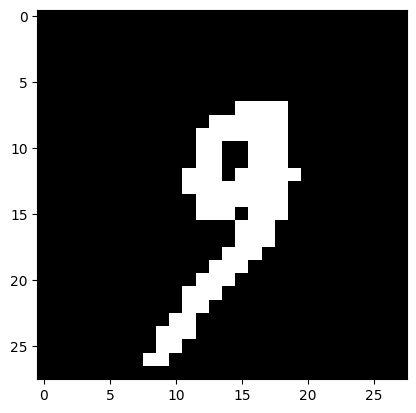

In [10]:
# apply otsu algorithm
# I want to maximise the inter class variance
# interclass variance = w1*varw1 + w2* var w2
def inter_class_variance(data,split_point):
  class1 = data[:split_point]
  class2 = data[split_point:]
  mu1 = np.mean(class1)
  mu2 = np.mean(class2)
  mu_total = np.mean(np.concatenate((class1, class2)))
  var1 = (mu1 - mu_total)**2
  var2 = (mu2 - mu_total)**2
  return var1 + var2

def find_threshold(data):
  data = np.sort(data)
  max_var = 0
  best_val = 0
  for val in range(256):
    inter_var = inter_class_variance(data,val)
    if inter_var > max_var:
      max_var = inter_var
      best_val = val
  return best_val

# Function to apply Otsu thresholding and create masks
def apply_otsu_threshold(image):
    # Apply Otsu thresholding
    _, mask = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return mask

masked_train = np.array([apply_otsu_threshold(img) for img in images_train])
masked_test = np.array([apply_otsu_threshold(img) for img in images_test])



In [ ]:
# Tight Ground Truth Circles
def get_tight_circle(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return [14, 14, 10]  # Default circle if no contour
    contour = max(contours, key=cv2.contourArea)
    (x, y), radius = cv2.minEnclosingCircle(contour)
    return [x, y, radius]

circles_train = np.array([get_tight_circle(mask) + [label] for mask, label in zip(masked_train, labels_train)])
circles_test = np.array([get_tight_circle(mask) + [label] for mask, label in zip(masked_test, labels_test)])


In [ ]:
# video background subtraction

import cv2
import numpy as np

video = cv2.VideoCapture(r"C:\Users\vinay\OneDrive\Desktop\courses\Sem-4\EE655\q5_18a4ee81-96e1-4415-94a6-c8e9521bce78\q5\denis_walk.avi")
bg_image = cv2.imread(r"C:\Users\vinay\OneDrive\Desktop\courses\Sem-4\EE655\q5_18a4ee81-96e1-4415-94a6-c8e9521bce78\q5\bg.png")

frames = []

while True:
    ret, frame = video.read()

    if not ret:
        break
    # frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    frames.append(frame)


initialFrame = frames[0]

def averageFrame(frames):
    add_frame = np.zeros(np.shape(frames[0]))
    for i in range(len(frames)):
        add_frame = add_frame + frames[i]
    return ((add_frame)/len(frames))

avg_frame = np.array(averageFrame(frames),dtype=np.uint8)

for i in range(len(frames)):
    # frame difference
    # cv2.imshow("vid1",frames[i+1] - frames[i])

    # frame - avg. frame
    # print(avg_frame)
    abs_mat = abs(frames[i] - avg_frame)
    # Convert difference to grayscale
    gray = cv2.cvtColor(abs_mat, cv2.COLOR_BGR2GRAY)

    # Apply Otsu's thresholding
    _, otsu_threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


    new_vid_frame = np.zeros_like(frames[i])
    for j in range(frames[0].shape[0]):
        for k in range(frames[0].shape[1]):
            if otsu_threshold[j,k] == 255:
                new_vid_frame[j,k] = frames[i][j,k]
            else:
                new_vid_frame[j,k] = bg_image[j,k]

    cv2.imshow("video",new_vid_frame)

    # frame - initial frame
    # cv2.imshow("vid3", frames[i+1] - initialFrame)

    cv2.waitKey(40)

video.release()
cv2.destroyAllWindows()


Cannot open video
